# Libraries and Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
import random as rand
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

In [ ]:
# def filter_image(image):

#   frame = image
#   hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#   # For pulling out all orange colors
#   lower_red = np.array([0,80,90])
#   upper_red = np.array([255,255,255])

#   mask = cv2.inRange(hsv, lower_red, upper_red)
#   res = cv2.bitwise_and(frame,frame, mask= mask)
#   imageRGB = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
#   return imageRGB

# img_names = os.listdir("/home/jetson/jetracer/notebooks/road_following_B/apex/")

# for name in img_names:
#     if(name != ".ipynb_checkpoints"):
#         image = cv2.imread("/home/jetson/jetracer/notebooks/road_following_B/apex/"+name)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         cv2.imwrite("/home/jetson/jetracer/notebooks/road_following_C/"+name,image)

# Data and Preprocessing

In [2]:
RAW_IMAGE_SIZE = (224,224)
TARGET_INPUT_SIZE = (224,224)
SEED = 42
BATCH_SIZE =1000
TEST_SPLIT = .2

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

test_X = []
test_Y = []
batch_index = 0

def filter_image(image):

  frame = image
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

  # For pulling out all orange colors
  lower_red = np.array([0,80,90])
  upper_red = np.array([255,255,255])

  mask = cv2.inRange(hsv, lower_red, upper_red)
  res = cv2.bitwise_and(frame,frame, mask= mask)
  imageRGB = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  return imageRGB

def get_data(path, image_names, batch_size):
  
  image_index = 0
  test_index = int(batch_size * TEST_SPLIT)

  train_X = []
  train_Y = []
  global test_X
  global test_Y
  global batch_index
    
  #Load training pixel information from images into X
  for i in range(batch_index,batch_index+batch_size):
    img = image_names[i]
    img_split = img.split('_')
    y = [int(img_split[0]),int(img_split[1])]
    image = cv2.imread(path+"/"+img)
    try:
        image = filter_image(image)
    except:
        break;
    
    image = image/255.0
    #image = tf.image.resize(image, TARGET_INPUT_SIZE)/255.0

    if(image_index > test_index):
      train_X.append(image)
      train_Y.append(y)
    else:
      test_X.append(image)
      test_Y.append(y)

    image_index += 1
    batch_index += 1
     
  #Convert arrays to numpy
  train_X = np.array(train_X)
  train_Y = np.array(train_Y)
  return train_X,train_Y


image_data_path = "/home/jetson/jetracer/notebooks/road_following_C/"
image_names = os.listdir(image_data_path)

# Model

In [4]:
# _input = Input(shape=(TARGET_INPUT_SIZE[0],TARGET_INPUT_SIZE[1],3))
# model = Conv2D(10, 2, (1,1), activation="relu")(_input)
# model = Flatten()(model)
# model = Dense(700, activation="sigmoid")(model)
# output = Dense(2, activation="linear")(model)
# model = keras.Model(inputs=_input, outputs=output, name="aicarnet")

# model.compile(optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.MSE,
#     metrics=["accuracy"])

# model.summary()

model = keras.Sequential()
model.add(Input(shape=(TARGET_INPUT_SIZE[0],TARGET_INPUT_SIZE[1],3)))

model.add(Conv2D(3, 3, (1,1), "same", activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(10, 3, (1,1), "same",  activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(20, 4, (1,1), "same",  activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(700, activation='sigmoid'))
model.add(Dense(2, activation='linear'))
model.compile(optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MSE,
    metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 10)      280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 20)        3220      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 20)        0

# Training

In [5]:
from IPython.display import clear_output

batch_index = 0
test_X = []
test_Y = []

num_batches = 8
num_per_batch = math.floor(len(image_names)/num_batches)
print("TOTAL IMGS: " + str(len(image_names)))
print("BATCH SIZE: " + str(num_per_batch))

for i in range(0,num_batches):
    train_X,train_Y = get_data(image_data_path,image_names, num_per_batch)
    history = model.fit(train_X, train_Y, epochs=200)
    del train_X
    del train_Y
    clear_output(wait=True)

ValueError: invalid literal for int() with base 10: '.ipynb'

# Evaluation

In [6]:
test_X = np.array(test_X)
test_Y = np.array(test_Y)

accuracy=history.history['accuracy']
loss=history.history['loss']

model.evaluate(test_X,test_Y)

2/2 [==============================] - 3s 1s/step - loss: 1568.9631 - accuracy: 0.8103


[1568.963134765625, 0.8103448152542114]

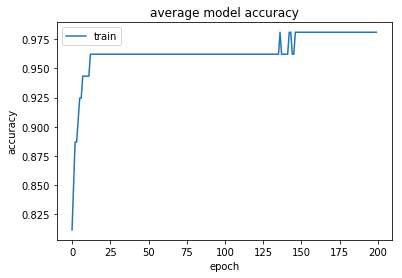

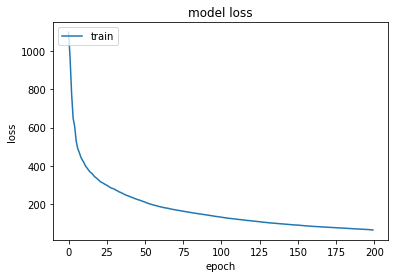

In [7]:
plt.plot(accuracy)
#plt.plot(history.history['val_accuracy'])
plt.title('average model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(loss)
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

2/2 - 1s


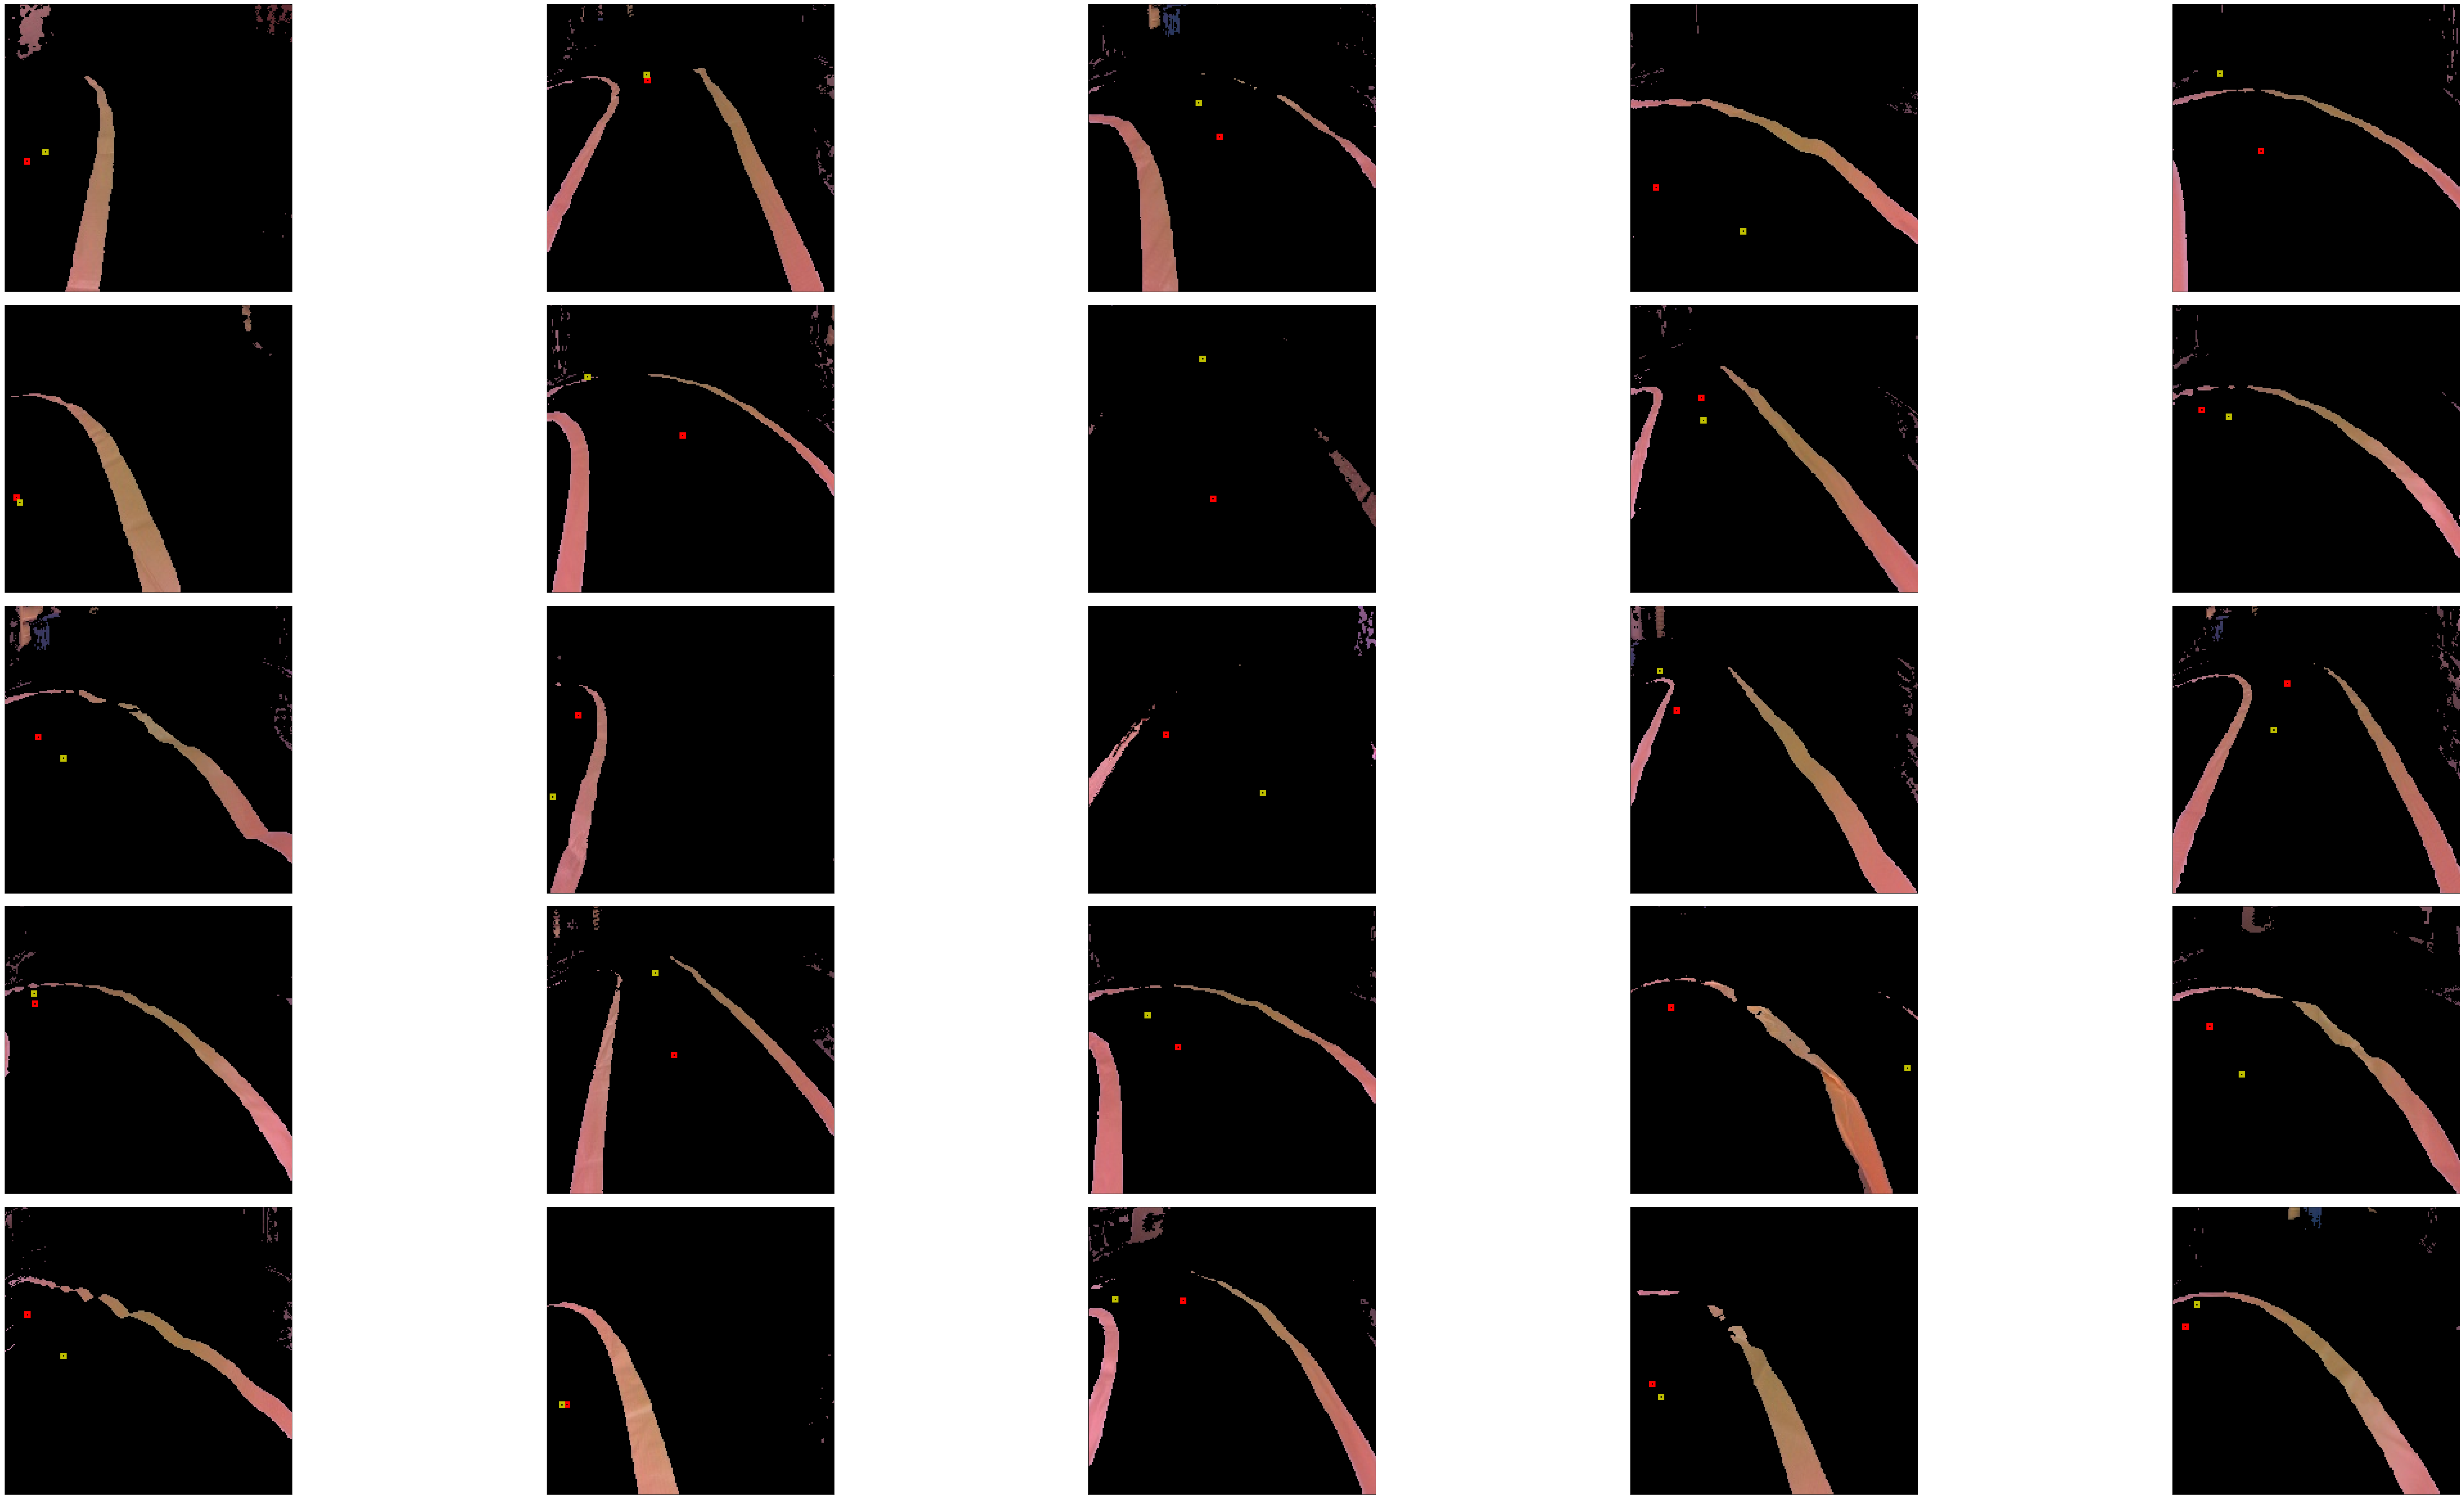

In [8]:
preds = model.predict(test_X,verbose=2)

i = 0

figure,ax = plt.subplots(5,5,figsize=(90,50))
figure.tight_layout()
for y in range(5):
  for x in range(5):
    ax[x][y].set_xticks([])
    ax[x][y].set_yticks([])

    rect = patches.Rectangle((preds[i][0],preds[i][1]),3,3,edgecolor='r',facecolor="none",lw=6.0)
    rect_T = patches.Rectangle((test_Y[i][0],test_Y[i][1]),3,3,edgecolor='y',facecolor="none",lw=6.0)
    ax[x][y].imshow(test_X[i])
    ax[x][y].add_patch(rect)
    ax[x][y].add_patch(rect_T)
    i+=1
plt.show()

In [9]:
model.save("./aicarmodel")

INFO:tensorflow:Assets written to: ./aicarmodel/assets
